In [1]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

def read_gz(filename):
    with gzip.open(filename) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        print("Found datastructure of shape", shape)
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

def plot_mnist(images, labels):
    N = len(labels)
    fig, ax = plt.subplots(ncols=N, figsize=(2*N, 2))
    for i in range(N):
        ax[i].imshow(images[i])
        ax[i].set_title(str(labels[i]))
    plt.show()

pwd = "/home/alyosha/Downloads/mnist_data/"
train_images = read_gz(pwd + "train-images-idx3-ubyte.gz")
train_labels = read_gz(pwd + "train-labels-idx1-ubyte.gz")
test_images = read_gz(pwd + "t10k-images-idx3-ubyte.gz")
test_labels = read_gz(pwd + "t10k-labels-idx1-ubyte.gz")

select_images = [0,1, 15, 138, 2000]
plot_mnist(train_images[select_images], train_labels[select_images])

Found datastructure of shape (60000, 28, 28)
Found datastructure of shape (60000,)
Found datastructure of shape (10000, 28, 28)
Found datastructure of shape (10000,)


/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


<Figure size 1000x200 with 5 Axes>

In [18]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def sig_sigprim(x):
    ep, em = np.exp(x), np.exp(-x)
    return 1 / (1 + em), 1 / (2 + em + ep)

def label2arr(x, N):
    arr = np.zeros(N)
    arr[x] = 1
    return arr

def computeAccuracy(yTrue1D, yPredicted2D):
    yPredicted1D = np.array([np.argmax(out) for out in yPredicted2D])
    return np.sum(yPredicted1D == yTrue1D) / yTrue1D.shape[0]

def trainTestNetwork(netClass, netParam, xTrain, yTrain, xTest, yTest, nY, nMini=1000, nEpoch=1001, nTimesSample=20):
    nTrialsTrain = xTrain.shape[0]
    nTrialsTest  = xTest.shape[0]
    nFeatures = np.prod(xTrain.shape[1:])
    
    # Convert data to format compatible with network [Trials x Features]
    xTrain2D  = xTrain.reshape(nTrialsTrain, nFeatures)
    xTest2D   = xTest.reshape(nTrialsTest, nFeatures)
    yTrain2D = np.array([label2arr(y, nY) for y in yTrain])
    yTest2D  = np.array([label2arr(y, nY) for y in yTest])
    
    # Initialize network
    netParam['nIn']  = nFeatures
    netParam['nOut'] = nY
    net = netClass(netParam)

    # Train network, trackign accuracy
    tSample = []
    lossProgress = []
    trainAccuracy = []
    testAccuracy = []
    sampleStep = nEpoch // nTimesSample
    for i in range(nEpoch):
        idxs = np.random.randint(0, nTrialsTrain, nMini)
        lossProgress += [net.step(xTrain2D[idxs], yTrain2D[idxs], 0.0001)]
        
        if i % sampleStep == 0:
            tSample += [i]
            trainAccuracy += [computeAccuracy(yTrain, net.predict(xTrain2D))]
            testAccuracy += [computeAccuracy(yTest, net.predict(xTest2D))]
        
    # Plot results
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].set_title("Loss function")
    ax[1].set_title("Accuracy")
    ax[0].set_xlabel("Epoch")
    ax[1].set_xlabel("Epoch")
    ax[0].plot(lossProgress)
    ax[1].plot(tSample, trainAccuracy, label='train')
    ax[1].plot(tSample, testAccuracy, label='train')
    ax[1].legend()
    plt.show()

# Shallow Neural Network

Have labelled data $x_{ij}$ with labels $y_{ik}$, where
* $i\in[1..N_{data}]$ is the number of datapoints
* $j\in[1..N_{in}]$ is the number of input features
* $k\in[1..N_{out}]$ is the number of label features

A shallow NN is defined by a linear operation, followed by a nonlinear operation.

$$
\begin{eqnarray}
l_k       &=& \sum_j W_{kj} x_j + b_k\\
\hat{y}_k &=& f(l_k)
\end{eqnarray}
$$

NN is optimized to perform well on average for all datapoints. This is described by a loss function

$$L^2 = \sum_{ik} L_{ik}^2 = \sum_{ik} (\hat{y}_{ik} - y_{ik})^2$$

Since it is a nonlinear function, it can't be minimized analytically. Instead, a gradient descent method can be applied to minimize it gradually

$$
\begin{eqnarray}
\tau \dot{W}_{uv}
&=& -\frac{1}{2}\frac{\partial L^2}{\partial W_{uv}}
= -\sum_{ik} L_{ik} f'_{ik} \sum_j \delta_{ku} \delta_{jv} x_{ij}
= -\sum_{i} L_{iu} f'_{iu} x_{iv}
&= \sum_{i} (y_{iu} - f_{iu}) f'_{iu} x_{iv} \\
\tau \dot{b}_{u}
&=& -\frac{1}{2}\frac{\partial L^2}{\partial b_{u}}
= ...
&= \sum_{i} (y_{iu} - f_{iu}) f'_{iu}
\end{eqnarray}
$$

So the algorithm is:
1. Init $W$ and $b$ with random numbers
2. Compute $f$ and $f'$ for each input
3. Thus, compute gradients for $W$ and $b$
4. Change $W$ and $b$ in the optimal direction
5. Check if have converged, if not, repeat from 1.

In [19]:
class ShallowNet:
    def __init__(self, p):
        self.b = np.random.normal(0,1, p['nOut'])
        self.W = np.random.normal(0,1, (p['nOut'], p['nIn']))
        
    def l(self, x, W, b):
        return x.dot(W.T) + b  # Flipped order to do vector broadcasting
        
    # Dimensions of x are [nTrial, nFeature]
    def predict(self, x):
        l = self.l(x, self.W, self.b)
        return sig(l)
    
    def step(self, x, y, eta):
        l = self.l(x, self.W, self.b)
        f, g = sig_sigprim(l)
        
        err = y - f
        errg = err*g
        self.b += eta * np.sum(errg, axis=0)
        self.W += eta * errg.T.dot(x)
        return np.mean(np.linalg.norm(err, axis=1))

/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/opt/anaconda3/envs/py37qt5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


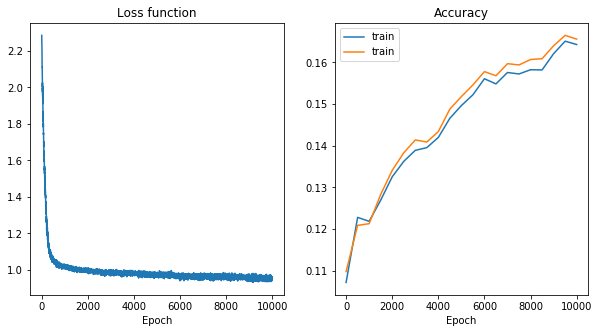

In [20]:
trainTestNetwork(ShallowNet, {}, train_images, train_labels, test_images, test_labels, 10, nMini=1000, nEpoch=10001)

# Deep Neural Network

Premise is the same, but now the network consists of several layers of weights and biases. There are now $M-1$ hidden layers $h$, and $M$ sets of weights and biases.

$$
\begin{eqnarray}
\hat{y}_k &=& f(l^M_k) \\
h^{n}_k   &=& f(l^{n-1}_k)\\
l^n_k     &=& \sum_j W^n_{kj} h^{n-1}_j + b^n_k \\
l^1_k     &=& \sum_j W^1_{kj} x_j + b^1_k
\end{eqnarray}
$$

For simplicity, define $g(x) = f'(x)$.
Computing derivatives of the loss function with respect to an abstract parameter $z$ we get

$$
\begin{eqnarray}
\frac{\partial L^2}{\partial z}
&=& \sum_{ik} L_{ik} g(l^M_{ik}) \sum_j W^M_{kj} \frac{\partial h_{ij}^{M-1}}{\partial z} \\
\frac{\partial h_{ij}^n}{\partial z}
&=& \sum_{k} g(l^n_{ik}) \sum_j W^n_{kj} \frac{\partial h_{ij}^{n-1}}{\partial z}
\end{eqnarray}
$$

Thus, the derivative with respect to particular weights and biases are (using Einstein summation notation)

$$
\begin{eqnarray}
\frac{\partial L^2}{\partial W^n_{uv}}
&=& 2 L_{ia} g^M_{ia} W^M_{ab} \cdot g^{M-1}_{ib} W^{M-1}_{bc} \cdot ... \cdot g^{n+1}_{if} W^{n+1}_{fu} \cdot g^{n}_{iu} h^{n-1}_{iv}\\
\frac{\partial L^2}{\partial b^n_{u}}
&=& 2 L_{ia} g^M_{ia} W^M_{ab} \cdot g^{M-1}_{ib} W^{M-1}_{bc} \cdot ... \cdot g^{n+1}_{if} W^{n+1}_{fu} \cdot g^{n}_{iu}
\end{eqnarray}
$$

To simplify the expression, let us define an intermediate variable

$$
\begin{eqnarray}
z^{M}_{ia} &=& -L_{ia} \\
z^n_{ia} &=& z^{n+1}_{ib} g^{n+1}_{ib} W^{n+1}_{ba} \\
\end{eqnarray}
$$

Rewriting the expressions for derivatives we get

$$
\begin{eqnarray}
\tau \dot{W}^n_{uv}
&=& -\frac{1}{2}\frac{\partial L^2}{\partial W^n_{uv}}
&= z^{n}_{iu} g^{n}_{iu} h^{n-1}_{iv} \\
\tau \dot{b}^n_{u}
&=& -\frac{1}{2} \frac{\partial L^2}{\partial b^n_{u}}
&= z^{n}_{iu} g^{n}_{iu}
\end{eqnarray}
$$

The forwards propagation algorithm is:
1. Input x_i for some minibatch of subset of datapoints
2. Progressively compute $h^n_i$ until $\hat{y}_i$ is computed
3. Compute loss function $L_i$, note performance

So the algorithm is:
1. Compute $g$ for this level
2. Compute $z$ for this level
3. Compute gradients for params at this level
4. Proceed to deeper level

In [ ]:
class DeepNet:
    def __init__(self, p):
        nNodeAll = [p['nIn']] + p['nHid'] + [p['nOut']]
        nAll = len(nNodeAll)
        
        self.b = []
        self.W = []
        for i in range(1, nAll):
            self.b += [np.random.normal(0,1, nNodeAll[i])]
            self.W += [np.random.normal(0,1, (nNodeAll[i], nNodeAll[i-1]))]
        
        
    def l(self, x, W, b):
        return x.dot(W.T) + b  # Flipped order to do vector broadcasting
        
    # Dimensions of x are [nTrial, nFeature]
    def predict(self, x):
        hThis = x
        for b, W in zip(self.b, self.W):
            l = self.l(hThis, W, b)
            hThis = sig(l)
        return hThis
    
    def step(self, x, y, eta):
        # Forwards pass
        h = []
        g = []
        hThis = x
        for b, W in zip(self.b, self.W):
            l = self.l(hThis, W, b)
            hThis, gThis = sig_sigprim(l)
            h += [hThis]
            g += [gThis]

        # Backwards pass
        z = [y - h[-1]]
        for i in range(len(self.b), 0, -1):
            zg = z[i] * g[i]
            z[i-1] = zg.dot(self.W[i])
            self.b[i] += eta * np.sum(zg, axis=0)
            self.W[i] += eta * zg.T.dot(h[i-1])
            
        return np.mean(np.linalg.norm(z[-1], axis=1))